# シフト最適化システム OptShift

> Shift Optimzation using SCOP (Solver for Constraint Programming)


In [ ]:
#| default_exp shift

In [ ]:
#| export
import random
import pandas as pd
import holidays
from faker import Faker
from collections import namedtuple, OrderedDict, defaultdict
import ast  #文字列からオブジェクトを起こすモジュール
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.express as px
import plotly
import numpy as np
import datetime as dt
import re
import json 

from openpyxl import Workbook, load_workbook
from openpyxl.worksheet.table import Table, TableStyleInfo
from openpyxl.chart import ScatterChart, Reference, Series
from openpyxl.worksheet.datavalidation import DataValidation
from openpyxl.formatting.rule import ColorScaleRule, CellIsRule, FormulaRule
from openpyxl.styles import Color, PatternFill, Font, Border, Alignment
from openpyxl.styles.borders import Border, Side
from openpyxl.comments import Comment

#import pdb
#%debug
import sys
sys.path.append('..')
from scmopt2.scop import *
#from scop import *
folder = "./data/shift/"

from ortools.sat.python.cp_model import CpModel, CpSolver
from ortools.sat.python import cp_model

TEST = False

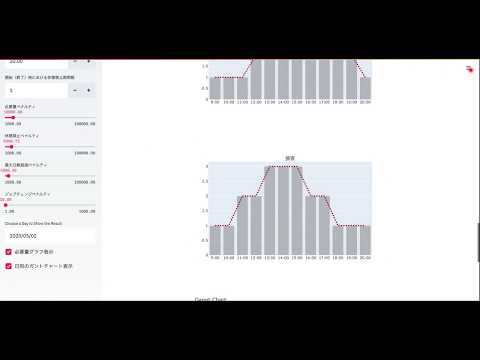

In [ ]:
#| echo: false
from IPython.display import Image, YouTubeVideo
YouTubeVideo("OmfDYolmT2g")

#hide
### シフト型の最適化モデル（時間帯を考慮しないモデル）

集合：

- $I$ : スタッフの集合 $= \{1,2, \ldots , i, \ldots|I|\} $ 
- $J_i$ : スタッフ $i$ が就くことができるシフトの集合 
- $T$ : 計画日の集合 $= \{1,2, \ldots , t, \ldots|T|\} $ 

パラメータ：

- $c_{ijt}$ : 日 $t$ にスタッフ $i$ がシフト $j$ に就くときの費用（希望休日出勤の場合には大きくする）．
- $LB_{jt}$ : 日$t$ のシフト $j$ で必要なスタッフの人数
- $p_{jt}$ : 日 $t$ のシフト $j$ のスタッフ不足時のペナルティ費用 
- $B_{i}$ : スタッフ $i$ の勤務日数

変数：

- $x_{ijt}$ : スタッフ　$i$　が日 $t$ にシフト $j$ に就くとき $1$、それ以外のとき $0$ を表す$0$-$1$変数

SCOPで解く場合は， 変数 $X_{it}$ を用い，その領域を $J_i$ とする．


- $y_{it}$: スタッフ　$i$　が日 $t$ に休むとき $1$、それ以外のとき $0$ を表す$0$-$1$変数

- $\xi_{jt}$ : 日　$t$, シフト $j$ のスタッフ不足数を表す整数変数


定式化：

- 目的関数（スタッフの費用と必要人数逸脱ペナルティの和）

$$
 minimize \ \ \sum c_{ijt} x_{ijt} + \sum p_{jt} \xi_{jt} 
$$

- スタッフがいずれかのシフトに就くか，休むことを表す制約

$$
  \sum  x_{ijt} + y_{it} = 1 \ \ \ \forall i,t 
$$

- 連続勤務最大日数　連続勤務は５日まで（6日間の間には必ず１つ休みが入る）

$$
\sum_{s=t}^{t+5} y_{is} \geq 1 \ \ \ \forall i,t 
$$


- 連休回避　４日連続の休みは回避（連続する４日の中の休みの合計が3以下；ただし希望休は除く）

$$
\sum_{s=t}^{t+3} y_{is} \leq 3 \ \ \ \forall i,t 
$$

- 必要人数下限制約

$$
  \sum_{i: j \in J_i}  x_{ijt} +\xi_{jt} \geq LB_{jt} \ \ \ \forall j,t 
$$

- 勤務日数制約

$$
 \sum y_{it} = B_i \ \ \ \forall i
$$


- スタッフ1が休みの時はスタッフ2は出勤とする制約

$$
 y_{1t} + y_{2t} \leq 1 \ \ \ \forall t 
$$


- 連続勤務最大日数； 「できるだけ」連続勤務は4日まで（5日間の間には必ず１つ休みが入る）

（破った場合の超過変数を追加し，目的関数にペナルティを入れる；以下同様）

$$
\sum_{s=t}^{t+4} y_{is} \geq 1 \ \ \ \forall i,t 
$$

- 休，出勤，休みのパターンをできるだけ回避

$$
y_{it} - y_{i,t+1} + y_{i, t+2} \leq 1 \ \ \ \forall i,t 
$$

- 遅番・早番の連続はできるだけ回避

遅番のシフトの集合を LATE，早番のシフトの集合を EARLYとする．

$$
\sum_{j \in LATE} x_{ijt} + \sum_{j \in EARLY} x_{ij,t+1}  \leq 1 \ \ \ \forall i,t 
$$


In [ ]:
#| include: false
# GUROBI = False  #サーバーの場合はFalseにする．

# if GUROBI:
#     from gurobipy import GRB, quicksum, Model
# else:
#     from pulp import PULP_CBC_CMD
#     from scmopt.mypulp import  GRB, quicksum, Model

# uploaded_xls = "optshift_sample4更新.xlsx"
# #uploaded_xls = "optshift_sample3.xlsx"
# #uploaded_xls = "optshift.xlsx"
# sheet = pd.read_excel(uploaded_xls, sheet_name=None, engine='openpyxl') #read all sheets 

# #対象とする月
# month =1 #or 12
# #必要人数が低か高か？
# high_or_low = "低" 

# #優先ジョブ（ファイルから読み込んで設定）
# # priority_job = [3,7]
# # penalty_normal = 100. #通常の逸脱ペナルティ
# # penalty_priority = 500. #役職者(priority_jobで指定）の逸脱ペナルティ
# # penalty_late = 200. #遅番の逸脱ペナルティ
    
# #希望休日出勤ペナルティ
# penalty_rest = 10000.
# #連続出勤5日のペナルティ, 休，出勤，休みのパターンのペナルティ, 遅番・早番の連続のペナルティのリスト
# penalty = [10.,10.,10.]
# #早番，遅番のシフト番号
# early = [3,4,5,6] 
# late =  [7,8,9,10]

# # 月の休み
# num_off = 9 

# day_df = sheet["day"+str(month)]
# staff_df = sheet["staff"+str(month)]
# job_df = sheet["job"] 
# #requirement_df = sheet["requirement"]
# requirement_df = sheet["requirement"+high_or_low]

# n_day  =len(day_df)
# n_job = len(job_df)
# n_staff =len(staff_df)

# # 要求タイプ、ジョブごとの必要人数を入れる辞書 requirement を準備
# # 早番，遅番，S夜勤は日別に必要人数を別途読み込む
# requirement = defaultdict(int) #使用しないジョブの必要人数を0にするため
# for row in requirement_df.itertuples():
#     requirement[row.day_type, row.job] = row.requirement

# # 休日希望日の集合を返す辞書 day_off[i]
# day_off = {}
# for i in range(n_staff):
#     off = staff_df.loc[i, "day_off"]
#     if pd.isnull(off):
#         day_off[i] = set([])
#     else:
#         day_off[i] = set( ast.literal_eval(str(off)) )
        
# #スタッフに割り当て可能なジョブのリストを準備
# #ジョブ0,1,2,12,13は未使用
# #avoid_job ={0,1,2,12,13}
# #12,13を追加
# avoid_job ={0,1,2}
# job_set ={}
# for i in range(n_staff):
#     job_set[i] = set(ast.literal_eval(staff_df.loc[i, "job_set"])) - avoid_job 

# #ジョブj,period tの必要人数を保管
# LB = defaultdict(int)
# for t, row in enumerate(day_df.itertuples()):
#     for j in range(n_job):
#         LB[j,t] = requirement[row.day_type, j] #既定の人数
        
# #ジョブ6,10,11の日別の下限制約の読み込み    
# lb_df = sheet[str(month)+high_or_low]
# job_list =[6,10,11]
# #job_list =[6,10,11,13]
# for t, row in enumerate(lb_df.itertuples()):
#     for idx, j in enumerate(job_list):
#         LB[j,t] = row[idx+3] #バイトを考慮した必要人数で上書き
#         #print(LB[j,t])

# # ジョブごとの逸脱ペナルティ
# penalty_lb = {j: 0 for j in range(n_job)}
# for i, row in enumerate(job_df.itertuples()):
#     #print(row.penalty)
#     penalty_lb[i] = int(row.penalty)
# # #下限逸脱ペナルティ（ジョブによって異なっても良い）
# # penalty_lb = {j: penalty_normal for j in range(n_job)}
# # #全体的に不足になる場合は早番よりも遅番を優先
# # for j in late:
# #     penalty_lb[j] = penalty_late
# # #役職者優先
# # for j in priority_job:
# #     penalty_lb[j] = penalty_priority
# # #中番ペナルティを1にする
# # for j in [12,13]:
# #     penalty_lb[j] = 1

In [ ]:
#| include: false
# penalty_lb

In [ ]:
#| include: false
# model = Model("sfift")
# x, y, lb_violation = {}, {}, {} #yは休み，lb_violationは逸脱量

# cost ={} #休日出勤を考慮して費用を設定（既定値は1）

# for i in range(n_staff):
#     for j in job_set[i]:
#         for t in range(n_day):
#             if t in day_off[i]:
#                 cost[i,j,t] = penalty_rest
#             else:
#                 cost[i,j,t] = 1.
#             x[i,j,t] = model.addVar(vtype="B", name= f"x[{i},{j},{t}]")
# for i in range(n_staff):
#     for t in range(n_day):
#         y[i,t] = model.addVar(vtype="B", name= f"y[{i},{t}]")
# for j in range(n_job):
#     for t in range(n_day):
#         lb_violation[j,t] = model.addVar(vtype="I", name= f"lb_violation[{j},{t}]")

# #連続出勤5日のペナルティ (0), 休，出勤，休みのパターンのペナルティ(1), 遅番・早番の連続のペナルティ(2) のための変数
# surplus = {}
# for i in range(n_staff):
#     for t in range(n_day):
#         for k in range(3):
#             surplus[k,i,t] = model.addVar(vtype="I", name= f"surplus[{k},{i},{t}]")
# model.update()

# #ジョブは高々1つ（もしくは休み）
# for i in range(n_staff):
#     for t in range(n_day):
#         model.addConstr(quicksum(x[i,j,t] for j in job_set[i]) + y[i,t] ==1,name= f"Assignment[{i},{t}]")

# #連続勤務最大日数　連続勤務は５日まで（6日間の間には必ず１つ休みが入る）
# for i in range(n_staff):
#     for t in range(n_day):
#         if t+6<n_day:
#             model.addConstr(quicksum(y[i,s] for s in range(t,t+6))>=1, name=f"ConsequtiveWork[{i},{t}]")
            
# #連休回避　４日連続の休みは回避（連続する４日の中の休みの合計が3以下）
# #ただし希望休は除く
# for i in range(n_staff):
#     for t in range(n_day):
#         consequtive_days = set(range(t,t+4))-day_off[i]
#         if t+4<n_day:
#             model.addConstr(quicksum(y[i,s] for s in consequtive_days)<=3, name=f"ConsequtiveRest[{i},{t}]")
            
# #できるだけの追加条件            
# #連続勤務最大日数　連続勤務は4日まで
# for i in range(n_staff):
#     for t in range(n_day):
#         if t+5<n_day:
#             model.addConstr(quicksum(y[i,s] for s in range(t,t+5))+surplus[0,i,t] >=1, name=f"ConsequtiveWork5[{i},{t}]")
            
# #休，出勤，休みのパターンのペナルティ
# for i in range(n_staff):
#     for t in range(n_day):
#         if t+3<n_day:
#             model.addConstr(y[i,t]-y[i,t+1]+y[i,t+2]<=1+surplus[1,i,t], name=f"RestWorkRest[{i},{t}]")
            
# #遅番・早番の連続のペナルティ
# for i in range(n_staff):
#     for t in range(n_day):  
#         if t+2<n_day:
#             model.addConstr(quicksum( x[i,j,t] for j in late if (i,j,t) in x)
#                             +quicksum( x[i,j,t+1] for j in early if (i,j,t) in x) <=1+surplus[2,i,t], name=f"LateEarly[{i},{t}]")

# #必要人数条件
# for t in range(n_day):
#     for j in range(n_job):
#         #ジョブ j, period t の下限制約
#         model.addConstr(quicksum( x[i,j,t] for i in range(n_staff) if (i,j,t) in x )
#                         + lb_violation[j,t] >=LB[j,t], name= f"LB[{j},{t}]")

# #休日数 (num_off = 9); 休日希望の場合もあるので， len(day_off[i])との大きい方に設定
# for i in range(n_staff):
#     model.addConstr(quicksum(y[i,t] for t in range(n_day))== max(num_off, len(day_off[i])), name=f"num_off[{i}]")

# #Staff1とStaff2のいずれかが出勤
# for t in range(n_day):
#     model.addConstr(y[0,t]+y[1,t]<=1, name= f"Staff Disjective{t}")
    
# #目的関数 
# model.setObjective( quicksum( cost[i,j,t]*x[i,j,t] for (i,j,t) in x)+ 
#                     quicksum(penalty_lb[j]*lb_violation[j,t] for (j,t) in lb_violation) + 
#                     penalty[k]*quicksum(surplus[k,i,t] for (k,i,t) in surplus ) , GRB.MINIMIZE)

In [ ]:
#| include: false
#model.write("shift.lp")
# model.optimize()
# eps = 0.001
# shift = np.zeros((n_staff,n_day)) #0が休みと仮定
# violation = np.zeros((n_job,n_day))
# for (i,j,t) in x:
#     if x[i,j,t].X >= 1.- eps:
#     #    print(i,j,t,x[i,j,t].X)
#         shift[i,t] = j
# print("下限逸脱[j,t]")
# for (j,t) in lb_violation:
#     if lb_violation[j,t].X > eps:
#         print(j,t,lb_violation[j,t].X)
#         violation[j,t] = lb_violation[j,t].X
# print("逸脱ペナルティ")
# for (k,i,t) in surplus:
#     if surplus[k,i,t].X > eps:
#         if k==0:
#             print("連続勤務最大日数 スタッフ",i,t,"日")
#         elif k==1:
#             print("休，出勤，休み スタッフ",i,t,"日")
#         else:
#             print("遅番・早番の連続 スタッフ",i,t,"日")
#         #print(k,i,t,surplus[k,i,t].X)

#hide

### Excel出力

Openpyxlを用いて，結果をExcelファイルに出力する．

In [ ]:
#| include: false
# LEFTSPACE = 3
# wb = Workbook()
# ws = wb.active 

# ws.column_dimensions["A"].width = 15
# ws.column_dimensions["B"].width = 15
# ws.column_dimensions["C"].width = 25
    
# ws.append( ["社員名", "可能なシフト", "希望休日"] + [day_df.day[d] for d in range(n_day)]+ ["休日合計"] )

# #日付フォーマット: 最大時刻まで
# _format = 'yyyy/m/d'  
# for t in range(n_day):
#     cell = ws.cell(1, LEFTSPACE+1+t)
#     cell.number_format = _format 
#     cell.alignment = Alignment(horizontal = "center", vertical = "center", textRotation = 90, wrap_text = False)

# for i, row in enumerate(staff_df.itertuples()):
#     ws.append( [row.name, row.job_set, row.day_off] + list(shift[i,:]) )

# ws.append(["合計"])
# for j, row in enumerate(job_df.itertuples()):
#     ws.append(["",j, row.description])
#     for t in range(n_day):
#         cell = ws.cell(3+n_staff+j, LEFTSPACE+1+t)
#         col = cell.column_letter #列名を抽出
#         cell.value = f"=COUNTIF({col}2:{col}{n_staff+1},{j})"  
#         #逸脱している場合には色を塗る
#         if violation[j,t] >= 1.:
#             side =Side(style="thick", color="00FF0000")            
#             cell.border = Border(left=side,top=side,right=side,bottom=side)

# ws.append(["必要人数"])
# for j, row in enumerate(job_df.itertuples()):
#     ws.append(["",j, row.description] +[LB[j,t] for t in range(n_day)])

# #休日合計
# cell = ws.cell(2, LEFTSPACE+n_day)
# col = cell.column_letter
# for j in range(n_staff):
#     cell = ws.cell(2+j, LEFTSPACE+n_day+1)
#     cell.value = f"=COUNTIF(D{2+j}:{col}{2+j},0)" 

# wb.save("optshift.xlsx")

## シフト最適化

実際問題から生じた以下の仮定の問題を高速に解くための関数群

問題は以下の仮定をもつ．

-　100人程度のスタッフ
-  30日程度の計画日
-  30分もしくは1時間単位の計画期（時間帯）
-  スタッフは作業が可能な業務が与えられている（スキルの設定）
-  休憩を入れるためのルール
-  スタッフのシフト希望
-  日・時間帯・作業ごとの必要人数下限

制約条件を満たす解のうちスタッフの費用の合計を最小化


## モデルの定式化

#hide

集合・パラメータ・変数を以下に示す.

集合：

- $I$ : スタッフの集合 $= \{1,2, \ldots , i, \ldots|I|\} $ 
- $J$ : スタッフが就く業務の集合 $= \{1,2, \ldots , j, \ldots|J|\} $ ；この中には休憩を表す $r$ が含まれるものとする。
- $D$ : 計画日の集合 $= \{1,2, \ldots , d, \ldots|D|\} $ 
- $T_{d}$ : 計画日$d$における計画期（時間帯；例えば１時間や30分を1単位とする）の集合  $= \{0,1, \ldots , t, \ldots|T_{d}|-1\} $ 
- $T'_{id}$ : スタッフ$i$の日$d$における勤務可能期の集合  $= \{t \mid o_{id} \leq t \leq e_{id}, t \in T_{d} \}$
（$o_{id}$と$e_{id}$ はそれぞれ開始可能期と終了期）
- $O_{id}$ : 日 $d$ にスタッフ$i$が、$\{s \mid o_{id} \leq s < e_{id}-m+1  , s \in T_{d}\}$ 期に勤務を開始し,
$\{t \mid s+m-1 \leq t \leq e_{id} , t \in T_{d}\}$期に勤務を終了するという組み合わせ$(s, t)$を要素とした集合 （$m$ は最低勤務期間数）

- $D_{w}$: 週 $w$ に含まれる日の集合
- $W$ : 週の集合 

パラメータ：

- $c_{ist}$ : スタッフ$i$が$s$期に勤務を開始し,$t$期に勤務を終了するときの費用
- $w_{ist}$ : スタッフ$i$が$s$期に勤務を開始し,$t$期に勤務を終了するときの（休憩時間を除いた）稼働期数
- $LB_{dtj}$ : 日$d$の期$t$に業務$j$で必要なスタッフの人数
- $h_{dtj}$ : 日$d$の期$t$における業務$j$のスタッフ不足時のペナルティ費用 
- $m$ : 最低勤務期間数.勤務開始から勤務終了まで$m$期以上勤務しなければならないものとする。
- $B_{i}$ : スタッフ$i$の計画期間中の勤務日数上限 
- $o_{id}$ : スタッフ$i$の日$d$における勤務開始可能期
- $e_{id}$ : スタッフ$i$の日$d$における勤務終了期限期
- $\tau_{st}$ : $s$期から$t$期まで勤務したときに必要な休憩期数 
- $\beta$ : 休憩を開始直後から（もしくは終了直前に）とることを禁止した期数 
- $\zeta_{i}$ : スタッフ$i$が勤務業務を変更したときのペナルティ費用


変数：

- $x_{idst}$ : スタッフ$i$が日$d$期$s$に勤務を開始し,期 $t$ に勤務を終了するとき $1$、それ以外のとき $0$ を表す$0$-$1$変数

- $y_{idtj}$: スタッフ$i$が日$d$期$t$に業務$j$に就くとき $1$、それ以外のとき $0$ を表す$0$-$1$変数

- $\xi_{dtj}$ : 日$d$, 期$t$, 業務$j$のスタッフ不足数を表す整数変数

- $u_{idtj}$ : スタッフ$i$が日$d$期$t$に勤務業務を休憩以外の別の勤務業務から$j$に変更したとき $1$、それ以外のとき $0$ を表す$0$-$1$変数


定式化：

$$
\begin{array}{lll}
 minimize & \sum_{ i \in I} \sum_{ d \in D} \sum_{(s,t) \in O_{id}}c_{ist} x_{idst} 
+ \sum_{ d \in D} \sum_{ t \in T_{d}} \sum_{j \in J} h_{dtj} \xi_{dtj} 
+ \sum_{i \in I} \sum_{d \in D} \sum_{t \in T_{d}} \sum_{j \in J_{i}} \zeta_{i} u_{idtj} &  \\
s.t. & \sum_{j \in J_{i}} y_{idkj} = \sum_{(s,t):s \leq k \leq t , (s,t) \in O_{id}} x_{idst} & \forall i \in I, d \in D, k \in T'_{id} \\
 & \sum_{(s,t) \in O_{id}} x_{idst} \leq 1  & \forall i \in I, d \in D  \\
 & \sum_{k \in T'_{id}} y_{idkr} = \sum_{(s,t) \in O_{id}} \tau_{st} x_{idst} &  \forall i \in I, d \in D \\
 & \sum_{i|j \in J_{i}} y_{idtj} + \xi_{dtj} \geq LB_{dtj} &  \forall d \in D, t \in T_{d}, j \in J  \\
& \sum_{d \in D} \sum_{(s,t) \in O_{id}} x_{idst} \leq B_{i} &  \forall i \in I \\
 & y_{idtj} - y_{id,t-1,j} - y_{id,t-1,r} \leq u_{idtj} & \forall i \in I, d \in D, t \in T_{d}, j \in J \\
 & \sum^{k+\beta}_{k'=k} y_{idk'r} \leq \beta\left(1 - \sum_{(s,t):s=k ,(s,t) \in O_{id}} x_{idst}\right)  & \forall i \in I, d \in D,  k \in T'_{d} \\
 & \sum^{k}_{k'=k-\beta} y_{idk'r} \leq \beta\left(1 - \sum_{(s,t):t=k ,(s,t) \in O_{id}} x_{idst}\right) & \forall i \in I, d \in D, k \in T'_{d} 　\\
 & \sum_{d \in D_w} \sum_{(s,t) \in O_{id}} w_{ist} x_{idst} \leq 40 &  \forall i \in I, w \in W \\
\end{array}
$$

目的関数は費用最小化である.
- 第1項は、スタッフに支払う賃金を表す.
- 第2項は、人員不足時のペナルティ費用を表す.
- 第３項は、業務変更の費用を表す。

制約：
- 変数$y_{idtj}$と変数$x_{idst}$の繋がりを表す制約
- 1計画日中に出勤・退勤は高々1度しかないことを表す制約
- 勤務期間内において労働時間に応じた休憩を取らなければならないことを表す制約
- 日$d$期$t$における業務$j$のスタッフの必要人数を満たすことを表す制約
- スタッフ$i$の労働期数の上限を表す制約
- 休憩 (添字 $r$) 以外からの業務変更を行うときの変数 $u_{idtj}$ と変数 $y_{idtj}$ の繋ぎ式
- 勤務開始直後・終了直前における休憩を禁止する制約
- 週あたりの稼働時間が法定の40時間を超えないことを表す制約（未実装）



## データ生成

日データ day_df （ファイル名はday.csv）

列：
- id : 0から始まる整数
- day : 日付
- day_of_week : 曜日；holidaysパッケージを用いて日本の祝日の場合には Holidayを入れる。
- day_type: 人数の必要量データは、この列の要素ごとに定義される。ここでは、平日 (weekday)、日曜 (sunday)と祝日(holiday)の3種類を準備する。

### 日データ生成関数 generate_day

引数：
- start_date: 開始日を表す文字列
- end_date: 終了日を表す文字列

返値：

day_df: 日データフレーム

In [ ]:
#| export
def generate_day(start_date, end_date):
    """
    日データ day_df 生成
    """
    jp_holidays = holidays.Japan()
    day_df = pd.DataFrame(pd.date_range(start_date, end_date, freq='D'), columns=["day"])
    day_df["day_of_week"] = [('Holiday') if  t in jp_holidays else (t.strftime('%a')) for t in day_df["day"] ] #曜日欄の追加
    n_day = len(day_df)

    row_ = []
    for row in day_df.itertuples():
        if row.day_of_week =="Holiday":
            row_.append("holiday")
        elif row.day_of_week =="Sun":
            row_.append("sunday")
        else:
            row_.append("weekday")
    day_df["day_type"] = row_
    day_df["id"] = [t for t in range(len(day_df))] 
    day_df = day_df.reindex(columns=["id", "day", "day_of_week", "day_type"])
    return day_df

### generate_day関数の使用例

In [ ]:
day_df = generate_day('2020-5-1', '2020-5-15')
#day_df.to_csv(folder+"day.csv")    
day_df

,id,day,day_of_week,day_type
0,0,2020-05-01,Fri,weekday
1,1,2020-05-02,Sat,weekday
2,2,2020-05-03,Holiday,holiday
3,3,2020-05-04,Holiday,holiday
4,4,2020-05-05,Holiday,holiday
5,5,2020-05-06,Holiday,holiday
6,6,2020-05-07,Thu,weekday
7,7,2020-05-08,Fri,weekday
8,8,2020-05-09,Sat,weekday
9,9,2020-05-10,Sun,sunday


In [ ]:
jp_holidays = holidays.Japan()
#dt.date(2015, 1, 1) in jp_holidays 
#print(jp_holidays)
day_df = pd.DataFrame(pd.date_range('2020-5-1', '2020-5-15', freq='D'),columns=["day"])
day_df["day_of_week"] = [('Holiday') if  t in jp_holidays else (t.strftime('%a')) for t in day_df["day"] ]
n_day = len(day_df)

row_ = []
for row in day_df.itertuples():
    if row.day_of_week =="Holiday":
        row_.append("holiday")
    elif row.day_of_week =="Sun":
        row_.append("sunday")
    else:
        row_.append("weekday")
day_df["day_type"] = row_
day_df["id"] = [t for t in range(len(day_df))] 
day_df = day_df.reindex(columns=["id", "day", "day_of_week", "day_type"])
day_df

,id,day,day_of_week,day_type
0,0,2020-05-01,Fri,weekday
1,1,2020-05-02,Sat,weekday
2,2,2020-05-03,Holiday,holiday
3,3,2020-05-04,Holiday,holiday
4,4,2020-05-05,Holiday,holiday
5,5,2020-05-06,Holiday,holiday
6,6,2020-05-07,Thu,weekday
7,7,2020-05-08,Fri,weekday
8,8,2020-05-09,Sat,weekday
9,9,2020-05-10,Sun,sunday


### 期間データ period_df (ファイル名 period.csv) 

1日のスケジュールは、基本時間単位の区間（これを期と呼ぶ）に対して決められる。
以下では、１時間を１期として生成するが、30分や15分でも構わない。
従来のシフトスケジューリングでは、6時間などを1期として扱うことが多かったが、本システムではより細かい時間単位を用いて最適化を行う。
これは、昨今の時間給で働く従業員が増えたことを考慮したものである。

列：
- id : 0から始まる整数
- description: 時間区分の説明；期の開始時刻を入れる。例えば、9:00という説明の期は9:00から10:00の区間を表す。 

### 期間データ生成関数 generate_period

引数：
- start_time: 開始期の開始時刻
- end_time: 終了期の終了時刻
- freq: 時間の刻みを表す文字列； 1時間（既定値）の場合は"1h"，30分の場合は"30min"と入力する．

返値：
period_df: 期間データフレーム

In [ ]:
#| export
def generate_period(start_time, end_time, freq="1h"):
    """
    期間データ生成関数 generate_period
    """
    period_df = pd.DataFrame(pd.date_range(start_time, end_time, freq=freq),columns=["description"])
    period_df["description"] = period_df.description.dt.strftime("%H:%M")
    period_df["id"] = [t for t in range(len(period_df))]
    period_df = period_df.reindex(columns = ["id", "description"])
    return period_df

### generate_period関数の使用例

9時から21時まで１時間刻みで期データを生成する． 
実際には０から11期までの12期分が計画期間になるが，終了時刻を表す21時(１２期)が最後に追加されている．これはガントチャートを描画するときに用いるだけである．

In [ ]:
#start_time = pd.to_datetime("9:00")
#end_time = pd.to_datetime("21:00")
start_time ="9:00"
end_time = "21:00"
period_df = generate_period(start_time, end_time, freq="1h")
period_df

,id,description
0,0,09:00
1,1,10:00
2,2,11:00
3,3,12:00
4,4,13:00
5,5,14:00
6,6,15:00
7,7,16:00
8,8,17:00
9,9,18:00


### 休憩データ break_df （ファイル名は break.csv) 

時間ごとのシフトスケジュールを組む際には、休憩を考慮することも重要になる。
ここでは、就業規則を反映した休憩データを準備するものとする。
これは、1日の稼働時間に対して、何期分の休憩を入れるかを定義したものである。
また、シフトの開始から（もしくは終了前の）何期の間は休憩を入れることができないといった制約も加える。

列：
- period : 1日のシフトの稼働時間（最低稼働期間は最初の期；以下の例では3期）
- break_time : 休憩を行う期の数

In [ ]:
# break.csv
random.seed(1)
T = 13
break_prob = 0.3
period_, break_ = [], []
min_work_time = 3
for t in range(min_work_time, T):
    period_.append(t)
    if t == min_work_time:
        break_ = [0]
    else:
        if random.random() <= break_prob:
            break_.append(break_[-1] + 1)
        else:
            break_.append(break_[-1])
break_df = pd.DataFrame({"period":period_, "break_time":break_})
#break_df.to_csv(folder + "break.csv")
break_df

,period,break_time
0,3,0
1,4,1
2,5,1
3,6,1
4,7,2
5,8,2
6,9,2
7,10,2
8,11,2
9,12,3


### 休憩時間設定用のExcelファイルを生成する関数 generate_break_excel 

引数：
- start_time: 開始期の開始時刻
- end_time: 終了期の終了時刻
- freq: 時間の刻みを表す文字列； 1時間（既定値）の場合は"1h"，30分の場合は"30min"と入力する．

返値：
wb: ExcelのWorkBookインスタンス

In [ ]:
#| export
def generate_break_excel(start_time, end_time, freq):
    period_df = generate_period(start_time, end_time, freq)
    wb = Workbook()
    ws = wb.active 
    data =[]
    ws.append(["期", "開始時刻", "休憩数"])
    for row in period_df.itertuples():
        ws.append([row.id, row.description, 0])
        
    #コメント
    ws.cell(1,1).comment = Comment("期ID（0から始まる整数）", "logopt")
    ws.cell(1,2).comment = Comment("期の開始時刻", "logopt")
    ws.cell(1,3).comment = Comment("最初の期に業務開始したときに必要な休憩期数", "logopt")
    return wb

#### generate_break_excel関数の使用例

In [ ]:
start_time = pd.to_datetime("9:00")
end_time = pd.to_datetime("13:00")
freq="30min"
wb = generate_break_excel(start_time, end_time, freq)

wb.save("break.xlsx")

### 必要人数設定用のExcelファイルを生成する関数 generate_requirement_excel

In [ ]:
#| export
def generate_requirement_excel(start_time, end_time, freq, job_list):
    period_df = generate_period(start_time, end_time, freq)
    T = len(period_df)-1
    day_type_list =['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'Holiday']+[ f"Special{i}" for i in range(1,4)]
    wb = Workbook()
    ws = wb.active
    wb.remove(ws)
    for d in day_type_list:
        ws = wb.create_sheet(d)
        #ws.append( ["  ","期"]+list(period_df.id[:-1]) ) #ヘッダが余分なので削除
        ws.append( ["業務","開始時刻"]+list(period_df.description[:-1]) )
        for i, job in enumerate(job_list):
            ws.append([i, job] +[0 for t in range(T)])
            
        #コメント
        ws.cell(1,1).comment = Comment("業務ID", "logopt")
        ws.cell(1,2).comment = Comment("業務名", "logopt")
        ws.cell(1,3).comment = Comment("時刻ごとの業務の必要人数", "logopt")
    return wb

In [ ]:
start_time = pd.to_datetime("9:00")
end_time = pd.to_datetime("13:00")
freq="30min"
job_list= ["レジ打ち", "バックヤード", "接客", "調理"]
wb = generate_requirement_excel(start_time, end_time, freq, job_list)
wb.save("requirement.xlsx")

### 日タイプ情報設定用のExcelファイルを生成する関数 generate_day_excel

In [ ]:
#| export
def generate_day_excel(start_date, end_date):
    """
    日データ day_df 生成
    """
    jp_holidays = holidays.Japan()
    day_df = pd.DataFrame(pd.date_range(start_date, end_date, freq='D'), columns=["day"])
    day_df["day_of_week"] = [('Holiday') if  t in jp_holidays else (t.strftime('%a')) for t in day_df["day"] ]
    day_df = day_df.reindex(columns=["day", "day_of_week"])
    wb = Workbook()
    ws = wb.active
    ws.append( ["日","日タイプ"] )
    for row in day_df.itertuples():
        ws.append([row.day.strftime('%Y-%m-%d'), row.day_of_week])
    #データバリデーションの追加（日タイプのみ）
    day_type_list =['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'Holiday']+[ f"Special{i}" for i in range(1,4)]
    stl = ",".join(day_type_list)
    dv = DataValidation(type="list", formula1= f'\"{stl}\"' , allow_blank=False)
    ws.add_data_validation(dv)
    dv.add('B2:B1048576') 
    
    #コメント
    ws.cell(1,1).comment = Comment("日（年-月-日）", "logopt")
    ws.cell(1,2).comment = Comment("日タイプ（曜日，休日，特別日1..3）", "logopt")
    return wb

In [ ]:
wb = generate_day_excel('2020-5-1', '2020-5-15')
wb.save("day.xlsx")

### スタッフ情報設定用のExcelファイルを生成する関数 generate_staff_excel

In [ ]:
#| export
def generate_staff_excel(job_list):
    wb = Workbook()
    ws = wb.active
    ws.append(["email", "秘密鍵", "優先度"] + job_list )
    ws.append(["sample@logopt.com","secret", 1 ]+[1 for i in job_list] )
    #データバリデーションの追加(0か1か)
    dv = DataValidation(type="decimal",
                    operator="between",
                    formula1=0,
                    formula2=1)
    ws.add_data_validation(dv)    
    cell = ws.cell(1, 3+len(job_list))
    col_name = cell.column_letter #列名を抽出
    dv.add(f'D2:{col_name}1048576') 
    
    #コメント
    ws.cell(1,1).comment = Comment("email（スタッフの電子メイル）", "logopt")
    ws.cell(1,2).comment = Comment("秘密鍵（スタッフが決めた秘密の文字列）", "logopt")
    ws.cell(1,3).comment = Comment("優先度（小さい値のスタッフが優先）", "logopt")
    ws.cell(1,4).comment = Comment("スタッフが業務（ジョブ）を遂行できるなら1，それ以外は0", "logopt")
    
    return wb

In [ ]:
job_list = ["レジ打ち", "バックヤード", "接客", "調理"]
wb = generate_staff_excel(job_list)
wb.save("staff.xlsx")

### ジョブ（業務）データ job_df （ファイル名は job_csv) 

列：
- id:  : 0から始まる整数
- description : ジョブ（業務、仕事）の名称；最初の行（idは0）には必ず休憩を表す"break"を入れておく。

In [ ]:
# job.csv
#description_ = ["break", レジ打ち", "バックヤード", "接客", "調理"]
description_ = ["break", "レジ打ち", "接客"]
n_job = len(description_)
id_ = [t for t in range(n_job)]
job_df = pd.DataFrame({"id":id_, "description":description_})
#job_df.to_csv(folder + "job.csv")
job_df

,id,description
0,0,break
1,1,レジ打ち
2,2,接客


### スタッフ（従業員）データ staff_df （ファイル名は staff.csv) 

列：
- name : スタッフの名前
- wage_per_period : 1期あたりの賃金
- max_period : 1日あたりの最大稼働時間
- max_day :　計画期間内に出勤できる最大日数
- job_set : スタッフに割り当てることが可能なジョブ（業務）の集合；ジョブidをリスト形式の文字列で入力する。
- day_off : 出勤できない日のidをリスト形式の文字列で入力する。
- start: 出勤可能な最早期id
- end: 退勤する最遅期id

In [ ]:
# staff.csv
fake = Faker(['en_US', 'ja_JP','zh_CN','ko_KR'])
Faker.seed(1)

n_day = len(day_df)
n_job = len(job_df)
n_staff = 30
name_ = []
job_list = list(job_df["id"][1:]) #最初のジョブは休憩なので除く
for i in range(n_staff):
    name_.append( fake.name() )

staff_df = pd.DataFrame( {"name": name_, 
                          "wage_per_period": np.random.randint(low=850,high=1300,size=n_staff),
                          "max_period": np.random.randint(5,break_df.period.max()+1, n_staff),
                          "max_day": np.random.randint(1,3, n_staff),
                          "job_set": [ str(random.sample(job_list,random.randint(1,n_job-1) )) for s in range(n_staff) ],
                          "day_off": [ str(random.sample( list(range(n_day)), 1 )) for s in range(n_staff) ],
                          #"day_off": [ "[]" for s in range(n_staff) ],
                          "start": np.random.randint(low=0, high=len(period_df)//2 -1, size= n_staff),
                           "end": np.random.randint(low=len(period_df)//2 + 1, high=len(period_df)-1, size= n_staff)
                         } )

#staff_df.to_csv(folder+"staff.csv")
staff_df

,name,wage_per_period,max_period,max_day,job_set,day_off,start,end
0,渡辺 直樹,1164,10,1,[2],[7],3,8
1,이상철,967,7,1,"[1, 2]",[13],3,9
2,전시우,999,9,1,"[1, 2]",[5],2,9
3,Deborah Pham,1134,6,2,"[1, 2]",[6],0,7
4,Amanda Johnson,1278,6,1,[1],[5],4,7
5,Jane Robinson,928,5,2,"[1, 2]",[0],1,8
6,박지연,1114,12,2,[1],[8],0,8
7,이정숙,1155,8,2,"[2, 1]",[8],4,9
8,남영자,1088,12,2,"[1, 2]",[9],0,8
9,Willie Heath,1025,12,1,"[2, 1]",[12],0,9


### 必要人数データ requirement_df （ファイル名は requirement.csv) 

列：
- day_type : day_dfの day_type列で入力した日の種類；この種類別に必要人数を定義する。
- job : ジョブid　
- period : 期id
- requirement : 必要人数

In [ ]:
# requirement
n_period = len(period_df)-1
day_type = ["weekday", "sunday", "holiday"]
type_, job_, period_, lb_ = [],[],[],[] 
for d in day_type:
    for j in range(1,n_job): #ジョブ番号0は休憩なので除く
        req_ = np.ones(n_period, int)
        lb = 0
        ub = n_period
        for iter_ in range(4):
            lb = lb + random.randint(1, 3)
            ub = ub - random.randint(1, 3)
            if lb < ub:
                for t in range(lb,ub):
                    req_[t]+=1
            
        for t in range(n_period):
            type_.append(d)
            job_.append(j)
            period_.append(t)
            lb_.append(req_[t])

requirement_df = pd.DataFrame({"day_type":type_, "job":job_, "period":period_,"requirement":lb_ })
#requirement_df.to_csv(folder+"requirement.csv")
requirement_df.head()

,day_type,job,period,requirement
0,weekday,1,0,1
1,weekday,1,1,1
2,weekday,1,2,2
3,weekday,1,3,2
4,weekday,1,4,2


## JSONデータをデータフレームに変換する関数 convert_shift_data 

Streamlitでfirebaseのデータベースから得たJSON形式のデータを最適化関数の入力となるデータフレームに変換する．


引数：
- day_json : 日JSONデータ
- break_df : 休憩JSONデータ
- staff_df : スタッフJSONデータ
- requirement_df : 必要人数JSONデータ
- min_work_periods: 最小稼働期間（既定値は1）

                                      
返値：
- period_df : 期間データフレーム
- break_df : 休憩データフレーム
- day_df : 日データフレーム
- job_df : ジョブデータフレーム
- staff_df : スタッフデータフレーム
- requirement_df : 必要人数データフレーム


In [ ]:
# with open("staff.json") as f:
#     staff_json = f.read()
# staff_data = pd.read_json(staff_json)
# staff_df = staff_data[ ["ニックネーム", "優先度", "最大稼働期間", "最大出勤日数", "開始時刻", "終了時刻", "日別希望時間"] ]
# #dic = staff_df.日別希望時間[1]
# day_dic ={d:t  for d,t in zip(day_df.day, day_df.index)}
# period_dic = {d:i for d,i in zip(period_df.description, period_df.id) }

# request = []
# for req in staff_df.日別希望時間:
#     if req is None or len(req)==0: 
#         request.append(None)
#         continue    

#     D ={}
#     for key in req:
#         try:
#             D[ day_dic[key] ] = (period_dic.get(req[key][0],0), period_dic.get(req[key][0],period_df.id.max()-1) )
#         except KeyError: #対応する日が計画期間内にない
#             pass
#     if len(D)>=1:
#         request.append(str(D))
#     else:
#         request.append(None)

In [ ]:
#| export
def convert_shift_data(day_json, break_json, staff_json, requirement_json, min_work_periods = 1):
    
    day_df = pd.read_json(day_json)
    period_df = pd.read_json(break_json)
    staff_data = pd.read_json(staff_json)
    req_dic =json.loads(requirement_json)
    requirement_dic ={}
    for d in req_dic:
        df = pd.read_json(req_dic[d])
        requirement_dic[d] = df
    
    day_df.rename(columns={"日":"day", "日タイプ":"day_type"}, inplace=True)
    period_df.rename(columns={"期":"id", "開始時刻":"description", "休憩数": "breaks"}, inplace=True)
    break_df = period_df.iloc[min_work_periods: , :]
    break_df.drop("description", axis=1, inplace=True)
    break_df.rename(columns={"id": "period", "breaks": "break_time"}, inplace =True)
    break_df.reset_index(inplace=True)
    break_df.drop("index", axis=1, inplace=True)
    
    #時刻を入れると期を返す辞書を準備
    period_dic = {d:i for d,i in zip(period_df.description, period_df.id) }
    #日を入れると何日目かを返す辞書を準備
    day_dic ={d:t  for d,t in zip(day_df.day, day_df.index)}

    staff_df = staff_data[ ["ニックネーム", "優先度", "最大稼働期間", "最大出勤日数", "開始時刻", "終了時刻", "日別希望時間"] ]
    job_data = staff_data.iloc[:,13:] #job data
    job_set = []
    for row in job_data.values:
        jobs = []
        for idx, i in enumerate(row):
            if i==1:
                jobs.append(idx+1)
        job_set.append( str(list(jobs))) 
    staff_df["job_set"] = job_set
    
    request = []
    for req in staff_df.日別希望時間:
        if req is None or len(req)==0: 
            request.append(None)
            continue    

        D ={}
        for key in req:
            try:
                D[ day_dic[key] ] = (period_dic.get(req[key][0],0), period_dic.get(req[key][0],period_df.id.max()-1) )
            except KeyError: #対応する日が計画期間内にない
                pass
        if len(D)>=1:
            request.append(str(D))
        else:
            request.append(None)
    staff_df["日別希望時間"] = request

    staff_df.rename(columns={"ニックネーム":"name", "優先度":"wage_per_period", "最大稼働期間": "max_period", 
                             "最大出勤日数":"max_day", "開始時刻":"start", "終了時刻":"end", "日別希望時間":"request"}, inplace=True)

    start_list = [period_dic.get(t,0) for t in staff_df.start ]
    end_list = [period_dic.get(t, period_df.id.max()-1) for t in staff_df.end ]
    staff_df["start"] = start_list
    staff_df["end"] = end_list

    Trans = {"月": "Mon", "火":"Tue", "水":"Wed", "木":"Thu", "金":"Fri", "土": "Sat", "日":"Sun"}
    day_off_list =[]
    for row in staff_data["出勤希望日"]:
        day_on =set([])
        for i in row: #ast.literal_eval(row): #=> day_off
            if i in Trans:
                day_on.add( Trans[i] )
        day_off = [] 
        for i,d in enumerate(day_df.day):
            day = pd.to_datetime(d)
            #print(i, day, day.strftime('%a'))
            if day.strftime('%a') not in day_on:
                day_off.append(i)
        day_off_list.append( str(day_off) )
    staff_df["day_off"] = day_off_list

    #requirement_df : day_type, job, period, requirement
    day_type, job, period, requirement =[],[],[],[]
    for day in requirement_dic:
        for row in requirement_dic[day].itertuples():
            for t, req in enumerate(row[3:]):
                #print(row.業務, t, req)
                day_type.append(day)
                job.append(row.業務+1) #0はbreak
                period.append(t)
                requirement.append(req)
    requirement_df = pd.DataFrame({"day_type": day_type, "job":job, "period":period, "requirement":requirement})
    #requirement_df
    job_list = ["break"]+ list(requirement_dic["Sun"].開始時刻)
    job_df = pd.DataFrame({"id": list(range(len(job_list)))  , "description": job_list} )
    
    return period_df, break_df, day_df, job_df, staff_df, requirement_df 

#### convert_shift_data関数の使用例

In [ ]:
# day_df = pd.read_excel("day.xlsx") #id, day, day_of_week, day_type
# break_df = pd.read_excel("break.xlsx") #id,description
# staff_data = pd.read_csv("staff.csv") #name (=nickname), wage_per_period (=priority), max_period, max_day, job_set, day_off, start, end
# requirement_dic = pd.read_excel("requirement.xlsx", sheet_name = None, header=1) 

# import json
# with open("day.json") as f:
#     day_json = f.read()
# with open("break.json") as f:
#     break_json = f.read()
# with open("staff.json") as f:
#     staff_json = f.read()
# with open("requirement.json") as f:
#     requirement_json = f.read()
        
# period_df, break_df, day_df, job_df, staff_df, requirement_df = convert_shift_data(day_json, break_json,
#                                                                                    staff_json, requirement_json, min_work_periods = 3)

# cost_df, violate_df, new_staff_df, job_assign, status = shift_scheduling(period_df, break_df, day_df, job_df, staff_df, requirement_df, theta=1,
#                     lb_penalty =10000, ub_penalty =10000, job_change_penalty = 10, break_penalty = 10000, max_day_penalty = 5000, 
#                     OutputFlag=False, TimeLimit=1, random_seed = 2)

## アナリティクス

スタッフの情報と必要人数データから，大まかな実行可能性を調べる．

スタッフが確率的にジョブや時間に割り当てられたと仮定して，必要量との比率を求め，可視化する．

In [ ]:
# n_day = len(day_df)
# n_job = len(job_df)
# n_period = len(period_df)-1
# work_hours = np.zeros( (n_job,n_day,n_period) )

# for row in staff_df.itertuples():
#     job_set = ast.literal_eval(row.job_set) 
#     day_off = set( ast.literal_eval(row.day_off) )
#     max_period = row.max_period  #最大稼働時間/１日の稼働時間 だけ加算する
#     max_day = row.max_day #最大稼働日数/計画期間 だけ加算する．
#     ratio = max_period/n_period * max_day/n_day
#     #print(ratio)
#     for d in range(n_day):
#         if d not in day_off:
#             for j in job_set:
#                 for t in range(row.start, row.end+1):
#                     work_hours[j,d,t]+= ratio
                   
# work_hours[1]

In [ ]:
# requirement ={}
# for row in requirement_df.itertuples():
#     requirement[row.day_type, row.period, row.job] = row.requirement
# req = np.zeros( (n_job, n_day, n_period) )
# for d, row in enumerate(day_df.itertuples()):
#     for j in range(1,n_job):
#         for t in range(n_period):
#             req[j,d,t] += requirement[row.day_type,t,j]

In [ ]:
# import seaborn as sns
# sns.heatmap(work_hours[1]/req[1], annot=True, fmt="1.2f");

In [ ]:
# fig = px.imshow(work_hours[1]/req[1], color_continuous_scale=px.colors.sequential.Viridis)
# fig.update_xaxes(side="top")
# plotly.offline.plot(fig);

### スタッフの希望と必要人数の関係を調べる関数 estimate_requirement

In [ ]:
#| export
def estimate_requirement(day_df, period_df, job_df, staff_df, requirement_df, days=None):
    
    n_day = len(day_df)
    if days is None:
        days = list( range(n_day) )     
    
    n_job = len(job_df)
    n_period = len(period_df)-1
    work_hours = np.zeros( (n_job,n_day,n_period) )

    for row in staff_df.itertuples():
        job_set = ast.literal_eval(row.job_set) 
        day_off = set( ast.literal_eval(row.day_off) )
        max_period = row.max_period  #最大稼働時間/１日の稼働時間 だけ加算する
        max_day = row.max_day #最大稼働日数/計画期間 だけ加算する．
        ratio = max_period/n_period * max_day/n_day
        #print(ratio)
        for d in range(n_day):
            if d not in day_off:
                for j in job_set:
                    for t in range(row.start, row.end+1):
                        work_hours[j,d,t]+= ratio
                        
    requirement ={}
    for row in requirement_df.itertuples():
        requirement[row.day_type, row.period, row.job] = row.requirement
    req = np.zeros( (n_job, n_day, n_period) )
    for d, row in enumerate(day_df.itertuples()):
        for j in range(1,n_job):
            for t in range(n_period):
                req[j,d,t] += requirement[row.day_type,t,j]
                   
    fig = make_subplots(rows=len(days), cols=n_job-1, shared_xaxes="all", shared_yaxes="all",
                       row_titles=[str(day_df.day.iloc[d]) for d in days], column_titles= [job_df.description.iloc[j] for j in range(1,n_job)] )

    for i,d in enumerate(days):
        for j in range(1,n_job):
            #必要量
            yy = [req[j,d,t] for t in range(n_period)]
            xx = period_df.description
            trace0 = go.Scatter(
                             x=xx,
                             y=yy,
                             mode='lines',
                             line = dict(color='firebrick', width=4, dash='dot'),
                             name="# of staffs required"
                             )
            fig.add_trace(
                trace0,
                row=i+1, col=j
            )
            #割当可能な人数
            trace1 = go.Bar(x=xx,
                         y= [ work_hours[j,d,t] for t in range(n_period)],
                         name="# of staffs",
                         marker_color='gray',
                         opacity = 0.5
                         )

            fig.add_trace(
                trace1,
                row=i+1, col=j
            )
    fig.update_layout(height=1000,title_text=f"# of staffs & lower bound for day {d}: dashed lines=LB, bar=estimated # of staffs", showlegend=False)
    
    return fig

In [ ]:
#fig = estimate_requirement(day_df, period_df, job_df, staff_df, requirement_df, days=[1,2,3])
#plotly.offline.plot(fig);

In [ ]:
#| echo: false
Image("../figure/estimate_requirement.png")

### 制約逸脱計算関数 evaluate_violation

引数：
- violated （最適化で得られた逸脱量を表す辞書）

返値：
- cost_df: 逸脱ペナルティを入れたデータフレーム

In [ ]:
#| export
def evaluate_violation(violated, x, period_df, day_df, staff_df):
    """
    制約逸脱計算関数 
    """
    n_day  =len(day_df)
    n_period = len(period_df) -1 #最後の期は終了期なので１を減じる
    n_staff =len(staff_df)
    
    cost_name =["total_cost", "staffLBConstr", "staffUBConstr", "changeJobConstr","breakLBConstr","noEarlyBreakConstr","noLateBreakConstr","totalUBConstr"]
    cost_name_ = ["Cost", "Staff Lower Bound", "Staff Upper Bound", "Change Job", "Break Number", "Early Break", "Late Break", "Max Work Day"]
    violation ={cn:0 for cn in cost_name}
    violate = np.zeros( (len(cost_name)-2, len(day_df) ) )
    totalUB = np.zeros( len(staff_df) )
    if violated is not None:
        for v in violated:
            for i, cn in enumerate(cost_name):
                if v[:len(cn)]==cn:
                    violation[cn] += violated[v]
                    #indexを抽出
                    idx = re.split('_|\]|\[', v)
                    if i==0:
                        pass
                    elif i in {3,4,5,6}: #change job, Break Number", "Early Break", "Late Break"
                        violate[i-1, int(idx[2]) ] += violated[v]
                    elif i==7: #total UB
                        totalUB[ int(idx[1]) ] += violated[v]
                    else:
                        violate[i-1, int(idx[1]) ] += violated[v]

    value_list =[ ]
    for cn in cost_name:    
        value_list.append( violation[cn] )
    cost_df = pd.DataFrame({"penalty": cost_name_, "value": value_list})
    violate_df = pd.DataFrame(violate, index= cost_name_[1:-1], columns=[f"Day {d}" for d in range(n_day)])

    #シフトの抽出
    arr=np.empty( (n_staff, n_day) ,dtype=object)
    for i in range(n_staff):
        for d in range(n_day):
            try:
                if x[i,d].value != f"{n_period}_{n_period}":
                    arr[i,d] = x[i,d].value
            except:
                pass
    shift_df = pd.DataFrame(arr, columns =[ f"Shift for Day {d}" for d in range(n_day)])
    new_staff_df = pd.concat([staff_df, shift_df], axis=1)
    new_staff_df["max day violation"] = totalUB
        
    return cost_df, violate_df, new_staff_df

### evaluate_violation関数の使用例

shift_schedulingの中で使用する．

## SCOP Model

制約最適化ソルバー SCOP を用いたモデルを記述する。

引数：

- period_df : 期間データフレーム
- break_df : 休憩データフレーム
- day_df : 日データフレーム
- job_df : ジョブデータフレーム
- staff_df : スタッフデータフレーム
- requirement_df : 必要人数データフレーム
- theta : 開始直後（もしくは終了直前）に休憩を禁止する期間数（既定値は1）
- lb_penalty : 必要人数を下回った場合のペナルティ（既定値は10000） 
- ub_penalty : 必要人数を上回った場合のペナルティ（既定値は0） 
- job_change_penalty : ジョブを切り替えたときのペナルティ（既定値は10） 
- break_penalty : 開始直後・終了直前の休憩を逸脱したときのペナルティ（既定値は10000） 
- max_day_penalty : 最大稼働日数を超過したときのペナルティ（既定値は5000） 
- OutputFlag : 出力フラグ；ソルバーの出力を出す場合にはTrue （既定値はFalse） 
- TimeLimit : 計算時間上限（既定値は10秒） 
- random_seed : ソルバーで用いる擬似乱数の種（既定値は1)
- cloud: 複数人が同時実行する可能性があるときTrue（既定値はFalse）; Trueのとき，ソルバー呼び出し時に生成されるファイルにタイムスタンプを追加し，計算終了後にファイルを消去する．
                                      
返値：
- x : 変数 $x$ を入れた辞書
- y : 変数 $y$ を入れた辞書
- sol : 解を表す辞書
- violated : 逸脱した制約を表す辞書
- new_staff_df : スタッフデータフレームにシフトを追加したもの 
- job_assign: スタッフに割り当てられたジョブの情報を保持した辞書
- status : 最適化の状態を表す数字；以下の意味を持つ。

|status | 意味|
| ---- | ---- |
|0               | 最適化成功 |  
|1  |  求解中にユーザが Ctrl-C を入力したことによって強制終了した． | 
|2  |  入力データファイルの読み込みに失敗した．   | 
|3  |  初期解ファイルの読み込みに失敗した． | 
|4  |  ログファイルの書き込みに失敗した． | 
|5  | 入力データの書式にエラーがある． | 
|6  | メモリの確保に失敗した．|
|7  | 実行ファイル scop.exe のよび出しに失敗した． | 
|10  | モデルの入力は完了しているが，まだ最適化されていない．| 
|負の値 | その他のエラー |

In [ ]:
#| export
def shift_scheduling(period_df, break_df, day_df, job_df, staff_df, requirement_df, theta=1,
                     lb_penalty =10000, ub_penalty=0, job_change_penalty = 10, break_penalty = 10000, max_day_penalty = 5000,
                    OutputFlag=False, TimeLimit=10, random_seed = 1, cloud=False):
    """
    シフト最適化
    """

    #最小稼働期間
    min_work_time = break_df.loc[0, "period"]
    #print("min work time = ", min_work_time)
    n_job = len(job_df)
    n_day  =len(day_df)
    n_period = len(period_df) -1 #最後の期は終了期なので１を減じる
    n_staff =len(staff_df)

    # 要求タイプ、ジョブ、期ごとの必要人数を入れる辞書 requirement を準備
    requirement ={}
    for row in requirement_df.itertuples():
        requirement[row.day_type, row.period, row.job] = row.requirement
        
    # 休日希望日の集合を返す辞書 day_off[i]
    day_off = {}
    for i in range(n_staff):
        day_off[i] = set( ast.literal_eval(staff_df.loc[i, "day_off"]) )

    # スタッフごとに開始時刻と終了時刻の組（パターン）を入れる辞書st_dicを準備（本来ならば日別）
    st_dic = defaultdict(list)
    start, end = {}, {} #スタッフの開始期と終了期
    max_period, max_day ={},{} #最大稼働期間と最大出勤日数
    for i, row in enumerate(staff_df.itertuples()):
        start[i] = int(row.start)
        end[i] = int(row.end)
        max_period[i] = int(row.max_period)
        max_day[i] = int(row.max_day)
        
    for i in range(n_staff):
        st_dic[i].append(f"{n_period}_{n_period}") # 割り当てがないことを表すダミー（費用は0)
        for s in range(start[i], end[i]-min_work_time+1):
            for t in range(s+min_work_time-1, end[i]+1):
                if s + max_period[i] < t:
                    break
                else:
                    st_dic[i].append(f"{s}_{t}")

    # 稼働時間に対する休憩時間数を返す辞書
    break_time = defaultdict(int)
    for t,b in zip(break_df.period, break_df.break_time):
        break_time[int(t)] = int(b)

    #スタッフに割り当て可能なジョブのリストを準備（n_job番目のジョブは割り当てがないことを表すダミー）
    job_set ={}
    for i in range(n_staff):
        job_set[i] = [0] + ast.literal_eval(staff_df.loc[i, "job_set"]) + [n_job]

    model = Model(name="sfift_scop")

    x = {}
    for i in range(n_staff):
        for d in range(n_day):
            if d in day_off[i]:
                continue
            x[i, d] = model.addVariable(name=f"x[{i}_{d}]", domain=st_dic[i])

    y = {}
    for i in range(n_staff):
        for d in range(n_day):
            if d in day_off[i]:
                continue
            for t in range(n_period):
                y[i, d, t] = model.addVariable(
                    name=f"y[{i}_{d}_{t}]", domain=job_set[i])

    #目的関数 
    total_cost = Linear("total_cost",rhs=0, direction="<=", weight=1)
    for i in range(n_staff):
        for d in range(n_day):
            if d in day_off[i]:
                continue
            for st in st_dic[i]:
                s, _ , e = st.partition("_")
                total_cost.addTerms( int((int(e)-int(s))*staff_df.loc[i,"wage_per_period"]), x[i,d], st)
                #print(start,e,st)
    model.addConstraint(total_cost)

    xyConstr = {} #xとyの繋ぎ式
    for i in range(n_staff):
        for d in range(n_day):
            if d in day_off[i]:
                continue
            #if staff.getAvailable_day(day.getID()):
            for t in range(n_period):
                xyConstr[i,d,t] = Linear(f"xyConstr[{i}_{d}_{t}]", rhs=0, direction="=", weight="inf")
                for j in job_set[i][:-1]: #dummyは除く
                    xyConstr[i,d,t].addTerms(1, y[i,d,t], j)
                for st in st_dic[i]:
                    if st==f"{n_period}_{n_period}":
                        continue # dummyは除く
                    s, _, e = st.partition("_")
                    if int(s) <=  t <= int(e):
                        xyConstr[i,d,t].addTerms(-1, x[i,d], st)
                model.addConstraint(xyConstr[i,d,t])
    #print(xyConstr[0,0,0])

    staffLBConstr = {} #スタッフの人数の下限制約
    for d in range(n_day):
        for t in range(n_period):
            for j in range(1,n_job): #最初のジョブは休憩なので除く
                req_type = day_df.loc[d,"day_type"]
                staffLBConstr[d,t,j] = Linear(f"staffLBConstr[{d}_{t}_{j}]",
                                                   rhs= requirement[req_type,t,j], direction=">=")
                for i in range(n_staff):
                    if d in day_off[i]:
                        continue
                    if j in set(job_set[i]):
                            staffLBConstr[d,t,j].addTerms(1, y[i,d,t], j)
                staffLBConstr[d,t,j].setWeight(lb_penalty)
                model.addConstraint(staffLBConstr[d,t,j])

    staffUBConstr = {} #スタッフの人数の上限制約
    for d in range(n_day):
        for t in range(n_period):
            for j in range(1,n_job): #最初のジョブは休憩なので除く
                req_type = day_df.loc[d,"day_type"]
                staffUBConstr[d,t,j] = Linear(f"staffUBConstr[{d}_{t}_{j}]",
                                                   rhs= requirement[req_type,t,j], direction="<=") 
                for i in range(n_staff):
                    if d in day_off[i]:
                        continue
                    if j in set(job_set[i]):
                            staffUBConstr[d,t,j].addTerms(1, y[i,d,t], j)
                staffUBConstr[d,t,j].setWeight(ub_penalty)
                model.addConstraint(staffUBConstr[d,t,j])
                
    changeJobConstr = {} #ジョブ変更のペナルティ
    for i in range(n_staff):
        for d in range(n_day):
            if d in day_off[i]:
                continue
            for t in range(1,n_period):
                for j in job_set[i][1:-1]: #休憩とダミーは除く
                    changeJobConstr[i,d,t,j] = Linear(f"changeJobConstr[{i}_{d}_{t}_{j}]", rhs=0, direction="<=")
                    changeJobConstr[i,d,t,j].addTerms( 1, y[i,d,t], j)
                    changeJobConstr[i,d,t,j].addTerms( -1, y[i,d,t-1], j)
                    changeJobConstr[i,d,t,j].addTerms( -1, y[i,d,t-1], 0 )
                    changeJobConstr[i,d,t,j].addTerms( -1, y[i,d,t-1], n_job ) #dummy 
                    changeJobConstr[i,d,t,j].setWeight(job_change_penalty)
                    model.addConstraint(changeJobConstr[i,d,t,j])

    breakLBConstr = {} #必要な休憩時間数の下限を表す制約
    for i in range(n_staff):
        for d in range(n_day):
            if d in day_off[i]:
                continue
            breakLBConstr[i,d] = Linear(f"breakLBConstr[{i}_{d}]", rhs=0, direction="=")
            for t in range(n_period):
                breakLBConstr[i,d].addTerms(1, y[i,d,t], 0) #0は休憩
            for st in st_dic[i]:
                s, _ , e = st.partition("_")
                breakLBConstr[i,d].addTerms(-1*int(break_time[int(e)- int(s)+1]), x[i,d], st)
            breakLBConstr[i,d].setWeight("inf")
            model.addConstraint(breakLBConstr[i,d])

    if theta >=1:
        noEarlyBreakConstr = {} #開始直後からtheta期は休憩を入れない
        for i in range(n_staff):
            for d in range(n_day):
                if d in day_off[i]:
                    continue
                
                for t in range(start[i],end[i]+1):  #スタッフiの開始・終了期    
                    noEarlyBreakConstr[i,d,t] = Linear(f"noEarlyBreakConstr[{i}_{d}_{t}]", rhs=theta, direction="<=")
                    
                    #右辺のx[idst]
                    no_x = True
                    for st in st_dic[i]:
                        s, _ , e = st.partition("_")
                        if int(s) == t:
                            noEarlyBreakConstr[i,d,t].addTerms(theta, x[i,d], st)
                            no_x = False
                    if no_x: #右辺のｘがない
                        break #それより遅いtだと見込みがないので終わって良い
                    
                    #左辺のｙ[i,d,k,r]
                    for k in range(t,t+theta):
                        noEarlyBreakConstr[i,d,t].addTerms(1, y[i,d,k], 0)

                    noEarlyBreakConstr[i,d,t].setWeight(break_penalty)
                    model.addConstraint(noEarlyBreakConstr[i,d,t])

        noLateBreakConstr = {} #終了直前のtheta期は休憩を入れない
        for i in range(n_staff):
            for d in range(n_day):
                if d in day_off[i]:
                    continue
                for t in range(end[i],start[i]-1,-1):  #スタッフiの開始・終了期（後ろから探索） 
                    noLateBreakConstr[i,d,t] = Linear(f"noLateBreakConstr[{i}_{d}_{t}]", rhs=theta, direction="<=")
                        
                    no_x = True
                    for st in st_dic[i]:
                        s, _ , e = st.partition("_")
                        if int(e) == t:
                            noLateBreakConstr[i,d,t].addTerms(theta, x[i,d], st)
                            no_x = False
                    if no_x:
                        break #今より早いtだと見込みがないので終わる．

                    for k in range(t-theta+1,t+1):
                        noLateBreakConstr[i,d,t].addTerms(1, y[i,d,k], "0")

                    noLateBreakConstr[i,d,t].setWeight(break_penalty)
                    model.addConstraint(noLateBreakConstr[i,d,t])

    totalUBConstr = {} #総稼働期間の上限制約
    for i in range(n_staff):
        totalUBConstr[i] = Linear(f"totalUBConstr[{i}]",rhs= max_day[i], direction="<=")
        for d in range(n_day):
            if d in day_off[i]:
                continue
            for st in st_dic[i]:
                if st != f"{n_period}_{n_period}": #ダミーのシフト
                    totalUBConstr[i].addTerms( 1, x[i,d], st)
        totalUBConstr[i].setWeight(max_day_penalty)
        model.addConstraint(totalUBConstr[i])

    model.Params.TimeLimit = TimeLimit
    model.Params.OutputFlag = OutputFlag
    model.Params.RandomSeed = random_seed

    sol, violated = model.optimize(cloud=cloud)
    
    #cost_df = evaluate_violation(violated)
    cost_df, violate_df, new_staff_df = evaluate_violation(violated, x, period_df, day_df, staff_df)
    
    #yの情報の保管（辞書のキーはJSONに変換できるように文字列にしておく）
    job_assign = {}
    for (i,d,t) in y:
        val_ = int(y[i,d,t].value )
        if  val_ != n_job:
            #print(i,d,t,val_)
            job_assign[ str( (i,d,t) ) ] = val_ 
            
    return cost_df, violate_df, new_staff_df, job_assign, model.Status

## SCOP（日別リクエスト）モデル

staff_dfに request列を追加

希望日をキー，開始，終了時刻を値

In [ ]:
#| export
def shift_scheduling2(period_df, break_df, day_df, job_df, staff_df, requirement_df, theta=1,
                     lb_penalty =10000, ub_penalty=0, job_change_penalty = 10, break_penalty = 10000, max_day_penalty = 5000,
                    OutputFlag=False, TimeLimit=10, random_seed = 1, cloud=False):
    """
    シフト最適化（スタッフが日毎に開始希望時刻と終了希望時刻を入れられるように変更）
    """

    #最小稼働期間
    min_work_time = break_df.loc[0, "period"]
    #print("min work time = ", min_work_time)
    n_job = len(job_df)
    n_day  =len(day_df)
    n_period = len(period_df) -1 #最後の期は終了期なので１を減じる
    n_staff =len(staff_df)

    # 要求タイプ、ジョブ、期ごとの必要人数を入れる辞書 requirement を準備
    requirement ={}
    for row in requirement_df.itertuples():
        requirement[row.day_type, row.period, row.job] = row.requirement
        
    # 休日希望日の集合を返す辞書 day_off[i]
    day_off = {}
    for i in range(n_staff):
        day_off[i] = set( ast.literal_eval(staff_df.loc[i, "day_off"]) )

    # スタッフごとに開始時刻と終了時刻の組（パターン）を入れる辞書st_dic[スタッフ,日] を準備

    start, end = {}, {} #スタッフの開始期と終了期（既定値）
    max_period, max_day ={},{} #最大稼働期間と最大出勤日数
    for i, row in enumerate(staff_df.itertuples()):
        start[i] = int(row.start)
        end[i] = int(row.end)
        max_period[i] = int(row.max_period)
        max_day[i] = int(row.max_day)

    st_dic = defaultdict(list)
    for i in range(n_staff):
        for d in range(n_day):
            st_dic[i,d].append(f"{n_period}_{n_period}") # 割り当てがないことを表すダミー（費用は0)
            #request列の辞書を参照
            req = staff_df.loc[i,"request"] 
            if req is None or len(req)==0:
                st_ = start[i]
                en_ = end[i]
            else:
                D = ast.literal_eval(staff_df.loc[i,"request"])
                if d in D:
                    st_, en_ =D[d]
                else:
                    st_ = start[i]
                    en_ = end[i]
            for s in range(st_, en_-min_work_time+1):
                for t in range(s+min_work_time-1, end[i]+1):
                    if s + max_period[i] < t:
                        break
                    else:
                        st_dic[i,d].append(f"{s}_{t}")

    # 稼働時間に対する休憩時間数を返す辞書
    break_time = defaultdict(int)
    for t,b in zip(break_df.period, break_df.break_time):
        break_time[int(t)] = int(b)

    #スタッフに割り当て可能なジョブのリストを準備（n_job番目のジョブは割り当てがないことを表すダミー）
    job_set ={}
    for i in range(n_staff):
        job_set[i] = [0] + ast.literal_eval(staff_df.loc[i, "job_set"]) + [n_job]

    model = Model(name="sfift_scop")

    x = {}
    for i in range(n_staff):
        for d in range(n_day):
            if d in day_off[i]:
                continue
            x[i, d] = model.addVariable(name=f"x[{i}_{d}]", domain=st_dic[i,d])

    y = {}
    for i in range(n_staff):
        for d in range(n_day):
            if d in day_off[i]:
                continue
            for t in range(n_period):
                y[i, d, t] = model.addVariable(
                    name=f"y[{i}_{d}_{t}]", domain=job_set[i])

    #目的関数 
    total_cost = Linear("total_cost",rhs=0, direction="<=", weight=1)
    for i in range(n_staff):
        for d in range(n_day):
            if d in day_off[i]:
                continue
            for st in st_dic[i,d]:
                s, _ , e = st.partition("_")
                total_cost.addTerms( int((int(e)-int(s))*staff_df.loc[i,"wage_per_period"]), x[i,d], st)
                #print(start,e,st)
    model.addConstraint(total_cost)

    xyConstr = {} #xとyの繋ぎ式
    for i in range(n_staff):
        for d in range(n_day):
            if d in day_off[i]:
                continue
            #if staff.getAvailable_day(day.getID()):
            for t in range(n_period):
                xyConstr[i,d,t] = Linear(f"xyConstr[{i}_{d}_{t}]", rhs=0, direction="=", weight="inf")
                for j in job_set[i][:-1]: #dummyは除く
                    xyConstr[i,d,t].addTerms(1, y[i,d,t], j)
                for st in st_dic[i,d]:
                    if st==f"{n_period}_{n_period}":
                        continue # dummyは除く
                    s, _, e = st.partition("_")
                    if int(s) <=  t <= int(e):
                        xyConstr[i,d,t].addTerms(-1, x[i,d], st)
                model.addConstraint(xyConstr[i,d,t])
    #print(xyConstr[0,0,0])

    staffLBConstr = {} #スタッフの人数の下限制約
    for d in range(n_day):
        for t in range(n_period):
            for j in range(1,n_job): #最初のジョブは休憩なので除く
                req_type = day_df.loc[d,"day_type"]
                staffLBConstr[d,t,j] = Linear(f"staffLBConstr[{d}_{t}_{j}]",
                                                   rhs= requirement[req_type,t,j], direction=">=")
                for i in range(n_staff):
                    if d in day_off[i]:
                        continue
                    if j in set(job_set[i]):
                            staffLBConstr[d,t,j].addTerms(1, y[i,d,t], j)
                staffLBConstr[d,t,j].setWeight(lb_penalty)
                model.addConstraint(staffLBConstr[d,t,j])

    staffUBConstr = {} #スタッフの人数の上限制約
    for d in range(n_day):
        for t in range(n_period):
            for j in range(1,n_job): #最初のジョブは休憩なので除く
                req_type = day_df.loc[d,"day_type"]
                staffUBConstr[d,t,j] = Linear(f"staffUBConstr[{d}_{t}_{j}]",
                                                   rhs= requirement[req_type,t,j], direction="<=") 
                for i in range(n_staff):
                    if d in day_off[i]:
                        continue
                    if j in set(job_set[i]):
                            staffUBConstr[d,t,j].addTerms(1, y[i,d,t], j)
                staffUBConstr[d,t,j].setWeight(ub_penalty)
                model.addConstraint(staffUBConstr[d,t,j])
                
    changeJobConstr = {} #ジョブ変更のペナルティ
    for i in range(n_staff):
        for d in range(n_day):
            if d in day_off[i]:
                continue
            for t in range(1,n_period):
                for j in job_set[i][1:-1]: #休憩とダミーは除く
                    changeJobConstr[i,d,t,j] = Linear(f"changeJobConstr[{i}_{d}_{t}_{j}]", rhs=0, direction="<=")
                    changeJobConstr[i,d,t,j].addTerms( 1, y[i,d,t], j)
                    changeJobConstr[i,d,t,j].addTerms( -1, y[i,d,t-1], j)
                    changeJobConstr[i,d,t,j].addTerms( -1, y[i,d,t-1], 0 )
                    changeJobConstr[i,d,t,j].addTerms( -1, y[i,d,t-1], n_job ) #dummy 
                    changeJobConstr[i,d,t,j].setWeight(job_change_penalty)
                    model.addConstraint(changeJobConstr[i,d,t,j])

    breakLBConstr = {} #必要な休憩時間数の下限を表す制約
    for i in range(n_staff):
        for d in range(n_day):
            if d in day_off[i]:
                continue
            breakLBConstr[i,d] = Linear(f"breakLBConstr[{i}_{d}]", rhs=0, direction="=")
            for t in range(n_period):
                breakLBConstr[i,d].addTerms(1, y[i,d,t], 0) #0は休憩
            for st in st_dic[i,d]:
                s, _ , e = st.partition("_")
                breakLBConstr[i,d].addTerms(-1*int(break_time[int(e)- int(s)+1]), x[i,d], st)
            breakLBConstr[i,d].setWeight("inf")
            model.addConstraint(breakLBConstr[i,d])

    if theta >=1:
        noEarlyBreakConstr = {} #開始直後からtheta期は休憩を入れない
        for i in range(n_staff):
            for d in range(n_day):
                if d in day_off[i]:
                    continue
                
                for t in range(start[i],end[i]+1):  #スタッフiの開始・終了期    
                    noEarlyBreakConstr[i,d,t] = Linear(f"noEarlyBreakConstr[{i}_{d}_{t}]", rhs=theta, direction="<=")
                    
                    #右辺のx[idst]
                    no_x = True
                    for st in st_dic[i,d]:
                        s, _ , e = st.partition("_")
                        if int(s) == t:
                            noEarlyBreakConstr[i,d,t].addTerms(theta, x[i,d], st)
                            no_x = False
                    if no_x: #右辺のｘがない
                        break #それより遅いtだと見込みがないので終わって良い
                    
                    #左辺のｙ[i,d,k,r]
                    for k in range(t,t+theta):
                        noEarlyBreakConstr[i,d,t].addTerms(1, y[i,d,k], 0)

                    noEarlyBreakConstr[i,d,t].setWeight(break_penalty)
                    model.addConstraint(noEarlyBreakConstr[i,d,t])

        noLateBreakConstr = {} #終了直前のtheta期は休憩を入れない
        for i in range(n_staff):
            for d in range(n_day):
                if d in day_off[i]:
                    continue
                for t in range(end[i],start[i]-1,-1):  #スタッフiの開始・終了期（後ろから探索） 
                    noLateBreakConstr[i,d,t] = Linear(f"noLateBreakConstr[{i}_{d}_{t}]", rhs=theta, direction="<=")
                        
                    no_x = True
                    for st in st_dic[i,d]:
                        s, _ , e = st.partition("_")
                        if int(e) == t:
                            noLateBreakConstr[i,d,t].addTerms(theta, x[i,d], st)
                            no_x = False
                    if no_x:
                        break #今より早いtだと見込みがないので終わる．

                    for k in range(t-theta+1,t+1):
                        noLateBreakConstr[i,d,t].addTerms(1, y[i,d,k], "0")

                    noLateBreakConstr[i,d,t].setWeight(break_penalty)
                    model.addConstraint(noLateBreakConstr[i,d,t])

    totalUBConstr = {} #総稼働期間の上限制約
    for i in range(n_staff):
        totalUBConstr[i] = Linear(f"totalUBConstr[{i}]", rhs= max_day[i], direction="<=")
        for d in range(n_day):
            if d in day_off[i]:
                continue
            for st in st_dic[i,d]:
                if st != f"{n_period}_{n_period}": #ダミーのシフト
                    totalUBConstr[i].addTerms( 1, x[i,d], st)
        totalUBConstr[i].setWeight(max_day_penalty)
        model.addConstraint(totalUBConstr[i])

    model.Params.TimeLimit = TimeLimit
    model.Params.OutputFlag = OutputFlag
    model.Params.RandomSeed = random_seed

    sol, violated = model.optimize(cloud=cloud)
    
    #cost_df = evaluate_violation(violated)
    cost_df, violate_df, new_staff_df = evaluate_violation(violated, x, period_df, day_df, staff_df)
    
    #yの情報の保管（辞書のキーはJSONに変換できるように文字列にしておく）
    job_assign = {}
    for (i,d,t) in y:
        val_ = int(y[i,d,t].value )
        if  val_ != n_job:
            #print(i,d,t,val_)
            job_assign[ str( (i,d,t) ) ] = val_ 
            
    return cost_df, violate_df, new_staff_df, job_assign, model.Status

In [ ]:
# cost_df, violate_df, new_staff_df, job_assign, status = shift_scheduling2(period_df, break_df, day_df, job_df, staff_df, requirement_df, theta=1,
#                     lb_penalty =10000, ub_penalty =10000, job_change_penalty = 10, break_penalty = 10000, max_day_penalty = 5000, 
#                     OutputFlag=False, TimeLimit=30, random_seed = 2)

In [ ]:
# cost_df

### shift_scheduling関数の使用例

In [ ]:
period_df = pd.read_csv(folder+"period.csv", index_col=0)
break_df = pd.read_csv(folder+"break.csv", index_col=0)
day_df = pd.read_csv(folder+"day.csv", index_col=0)
job_df = pd.read_csv(folder+"job.csv", index_col=0)
staff_df = pd.read_csv(folder+"staff.csv", index_col=0)
requirement_df = pd.read_csv(folder+"requirement.csv", index_col=0)

cost_df, violate_df, new_staff_df, job_assign, status = shift_scheduling(period_df, break_df, day_df, job_df, staff_df, requirement_df, theta=1,
                    lb_penalty ="inf", ub_penalty =0, job_change_penalty = 10, break_penalty = 10000, max_day_penalty = 5000, 
                    OutputFlag=False, TimeLimit=30, random_seed = 2)


 ================ Now solving the problem ================ 



In [ ]:
#cost_df

,penalty,value
0,Cost,0
1,Staff Lower Bound,0
2,Staff Upper Bound,0
3,Change Job,0
4,Break Number,0
5,Early Break,0
6,Late Break,0
7,Max Work Day,0


In [ ]:
# violate_df

In [ ]:
#job_assign

In [ ]:
#new_staff_df

In [ ]:
#fig = make_requirement_graph(day_df, period_df, job_df, staff_df, requirement_df, job_assign, day=1)
#plotly.offline.plot(fig);

In [ ]:
#fig = make_gannt_for_shift(day_df, period_df, staff_df, job_df, job_assign, day=1 )
#plotly.offline.plot(fig);

## Excel出力

### 日ごとのジョブのガントチャートのExcel Workbookを生成する関数 make_gannt_excel 

引数：
- job_assign: スタッフに割り当てられたジョブの情報を保持した辞書
- period_df : 期間データフレーム
- day_df : 日データフレーム
- job_df : ジョブデータフレーム
- staff_df : スタッフデータフレーム
- requirement_df : 必要人数データフレーム
             
返値：
wb: Excel (OptnPyXL) のWorkBookオブジェクト

In [ ]:
#| export
def make_gannt_excel(job_assign, period_df, day_df, job_df, staff_df, requirement_df):
    LEFTSPACE = 2 #Excelの左の空白数

    # 要求タイプ、ジョブ、期ごとの必要人数を入れる辞書 requirement を準備
    requirement ={}
    for row in requirement_df.itertuples():
        requirement[row.day_type, row.period, row.job] = row.requirement

    n_staff = len(staff_df)
    n_day = len(day_df)
    n_period = len(period_df)-1
    n_job = len(job_df)
    
    #割り当てジョブを配列に入れる
    job_array = np.zeros(shape=(n_staff, n_day, n_period), dtype=int)
    for idx_str in job_assign:
        #i,d,t = map(int, idx_str[1:-1].split(",")) 
        i,d,t = ast.literal_eval(idx_str)
        job_array[i,d,t] = job_assign[idx_str]

    wb = Workbook()
    ws0 = wb.active
    wb.remove(ws0)
    for day in range(n_day):
        ws = wb.create_sheet(title= day_df.day[day]) #日付に変換
        data = job_array[:,day,:]
        ws.append([""]*LEFTSPACE + list(period_df.description[:-1]))
        #スタッフごとのジョブデータをシートに追加
        for i, row in enumerate(list(data)):
            ws.append([i , staff_df.name[i] ] + list(row))

        ws.append(["人数","期"] + [t for t in range(n_period)]) #散布図にするため期にする
        #ws.append(["人数","時刻"] + list(period_df.description[:-1]))
        #ジョブのカウントを計算するためのセルを追加
        for j in range(1,n_job):
            for col in range(LEFTSPACE+1, LEFTSPACE + n_period +1):
                cell = ws.cell(n_staff+2+j, col)
                col_name = cell.column_letter #列名を抽出
                cell.value = f"=COUNTIF({col_name}2:{col_name}{n_staff+1},{j})" 
        #ジョブの名前と番号を1,2列に追加
        for j in range(1,n_job):
            cell = ws.cell(n_staff+2+j, 1)
            cell.value = j
            cell = ws.cell(n_staff+2+j, 2)
            cell.value = job_df.description[j]
        #必要人数の追加
        req_type = day_df.loc[day,"day_type"]
        ws.append(["必要人数"])
        for j in range(1,n_job):
            ws.append( [j, str(job_df.description[j])+" 下限"] + [requirement[req_type,t,j] for t in range(n_period) ] )  
        #Tableの定義
        tab = Table(displayName=f"Table{day}", ref= f"C1:{col_name}{n_staff+1}")
        style = TableStyleInfo(name="TableStyleMedium9", showFirstColumn=False,
                               showLastColumn=False, showRowStripes=True, showColumnStripes=False)
        tab.tableStyleInfo = style
        ws.add_table(tab)

        #チャートの描画
        for j in range(1, n_job):
            c1 = ScatterChart()
            c1.title = "必要人数チャート"
            c1.style = 13
            c1.y_axis.title = '人数'
            c1.x_axis.title = '期'
            xvalues = Reference(ws, min_col=LEFTSPACE+1, min_row=n_staff+2, max_col=LEFTSPACE+n_period)
            yvalues1 = Reference(ws, min_col=LEFTSPACE, min_row=n_staff+2+j, max_col=LEFTSPACE+n_period)
            series1 = Series(yvalues1, xvalues, title_from_data=True)
            series1.marker.symbol = "triangle"
            series1.marker.graphicalProperties.solidFill = "FF0000" # Marker filling
            series1.marker.graphicalProperties.line.solidFill = "FF0000" # Marker outline
            series1.graphicalProperties.line.noFill = True
            c1.series.append(series1)
            yvalues2 = Reference(ws, min_col=LEFTSPACE, min_row=n_staff+2+j+n_job, max_col=LEFTSPACE+n_period)
            series2 = Series(yvalues2, xvalues, title_from_data=True)
            series2.graphicalProperties.line.solidFill = "00AAAA"
            series2.graphicalProperties.line.dashStyle = "sysDot"
            series2.graphicalProperties.line.width = 100050 # width in EMUs
            #series2.smooth = True # Make the line smooth
            c1.series.append(series2)
            ws.add_chart(c1, f"A{n_staff+n_job*2+5 + (j-1)*20}")
    return wb

#### make_gannt_excel関数の使用例

In [ ]:
# wb = make_gannt_excel(job_assign, period_df, day_df, job_df, staff_df, requirement_df)
# wb.save("shift_gannt.xlsx")

### 期間内のシフト一覧を出力する関数 make_allshift_excel

引数：
- new_staff_df : スタッフデータフレーム（シフトを追加したもの）
- day_df : 日データフレーム
             
返値：
wb: Excel (OptnPyXL) のWorkBookオブジェクト

In [ ]:
#| export
def make_allshift_excel(new_staff_df, day_df, period_df):
    n_day = len(day_df)
    n_staff = len(new_staff_df)
    
    #period_dic = {d:i for d,i in zip(period_df.description, period_df.id) } #逆写像も作る！
    period_dic = {i:d for d,i in zip(period_df.description, period_df.id) } #ID => 時刻
    
    LEFTSPACE = 2
    shift = new_staff_df.iloc[:,9:-1]
    wb = Workbook()
    ws = wb.active 
    data =[]
    for row in shift.values:
        L1, L2, L3 = [], [], []
        for j in row:
            if j is None:
                L1.append("")
                L2.append("")
                L3.append(0)
            else:
                s,f = map(int, j.split("_"))
                L1.append( period_dic[s])
                L2.append( period_dic[f])
                L3.append(f-s)
        data.append(L1)
        data.append(L2)
        data.append(L3)
    ws.append([""]*LEFTSPACE + [day_df.day[d] for d in range(n_day)]+["合計"]) #日付に変換 
    #シフトデータ出力
    for i, row in enumerate(list(data)):
        if i%3==0:
            ws.append([i//3 , new_staff_df.name[i//3] ] + row)
        else:
            ws.append([ "", ""] + row)

    # n_day+6列目に行の和の関数を代入
    for i in range(n_staff):
        row = 4 + i*3
        cell = ws.cell(row, LEFTSPACE+n_day+1)
        last_column = ws.cell(1,LEFTSPACE+n_day).column_letter
        cell.value = f"=SUM(C{row}:{last_column}{row})" 
            
    #Tableの定義
    tab = Table(displayName=f"ShiftTable", ref= f"C1:{last_column}{n_staff*3+1}")
    style = TableStyleInfo(name="TableStyleMedium9")
    tab.tableStyleInfo = style
    ws.add_table(tab)
    return wb

#### make_allshift_excel関数の使用例

In [ ]:
# wb = make_allshift_excel(new_staff_df, day_df, period_df)
# wb.save("all_shift.xlsx")

In [ ]:
# pd.read_excel("all_shift.xlsx")

## 可視化

### 必要人数を描画する関数 make_requirement_graph

引数：
- day_df : 日データフレーム
- period_df : 期間データフレーム
- job_df : ジョブデータフレーム
- staff_df : スタッフデータフレーム
- requirement_df : 必要人数データフレーム
- job_assign : 変数 $y$ の情報（スタッフiが日dの期tに割り当てられたジョブの番号）を入れた辞書（キーは文字列）
- day : 描画したい日のid
                                      
返値：
- fig : Plotlyのグラフオブジェクト


In [ ]:
#| export
def make_requirement_graph(day_df, period_df, job_df, staff_df, requirement_df, job_assign, day=0):
    """
    必要人数のグラフを生成する関数
    """

    n_day = len(day_df)
    n_period = len(period_df)-1
    n_job = len(job_df)
    n_staff = len(staff_df)

    req_type = day_df.loc[day,"day_type"]
    
    # 要求タイプ、ジョブ、期ごとの必要人数を入れる辞書 requirement を準備
    requirement ={}
    for row in requirement_df.itertuples():
        requirement[row.day_type, row.period, row.job] = row.requirement
        
    # 休日希望日の集合を返す辞書 day_off[i]
    day_off = {}
    for i in range(n_staff):
        day_off[i] = set( ast.literal_eval(staff_df.loc[i, "day_off"]) )
    
    y = {}
    for key in job_assign:
        tpl = ast.literal_eval(key)
        y[tpl] = job_assign[key]
        
    #人数の計算
    val = np.zeros((n_day,n_period,n_job+1),int)
    for d in range(n_day):
        for t in range(n_period):
            for i in range(n_staff):
                if d in day_off[i]:
                    continue
                j = int(y.get( (i,d,t), 0) )
                #print(i,d,t,"=",j)
                val[d,t,j] += 1

    fig = make_subplots(rows=n_job-1, cols=1, subplot_titles= [job_df.description.iloc[j] for j in range(1,n_job)] )
    for j in range(1,n_job):

        yy = [requirement[req_type,t,j] for t in range(n_period)]
        xx = period_df.description

        trace0 = go.Scatter(x=xx,
                         y=yy,
                         mode='lines',
                         #marker=dict(
                         #   size=30, color="blue", opacity=0.8
                         #),
                         line = dict(color='firebrick', width=4, dash='dot'),
                         name="# of staffs required"
                         )
        #    print(s,d,t,day,y[s,d,t].value,job)
        trace1 = go.Bar(x=xx,
                     y=val[day,:,j],
                     name="# of staffs",
                     marker_color='gray',
                     opacity = 0.5
                     )

        fig.add_trace(
            trace0,
            row=j, col=1
        )
        fig.add_trace(
            trace1,
            row=j, col=1
        )
    #fig.update_layout(height=1000,title_text=f"Number of staffs and lower bound for day {day}", showlegend=False)
    fig.update_layout(height=1000, showlegend=False)


    return fig

### make_requirement_graphの使用例

In [ ]:
# print("Status",status)
# if status ==0: #SCOPが失敗していないときのみ表示
#     fig = make_requirement_graph(day_df, period_df, job_df, staff_df, requirement_df, job_assign, day = 0)
#     plotly.offline.plot(fig);

In [ ]:
#| echo: false
Image("../figure/requirement_for_shift.png")

### ガントチャートを描画する関数 make_gannt_for_shift

引数：
- day_df : 日データフレーム
- period_df : 期間データフレーム
- staff_df : スタッフデータフレーム
- job_df : ジョブデータフレーム
- requirement_df : 必要人数データフレーム
- job_assign : 変数 $y$ の情報（スタッフiが日dの期tに割り当てられたジョブの番号）を入れた辞書（キーは文字列）
- day_off : 希望休日を入れた辞書
- day : 描画したい日のid
                                      
返値：
- fig : Plotlyのグラフオブジェクト


In [ ]:
#| export
def make_gannt_for_shift(day_df, period_df, staff_df, job_df, job_assign, day=0 ):
    """
    スタッフごとのガントチャートを生成する関数
    """
    n_period = len(period_df)-1
    n_job = len(job_df)
    n_staff = len(staff_df)
    #変数yの準備
    y = {}
    for key in job_assign:
        tpl = ast.literal_eval(key)
        y[tpl] = job_assign[key]
        
    # 休日希望日の集合を返す辞書 day_off[i]
    day_off = {}
    for i in range(n_staff):
        day_off[i] = set( ast.literal_eval(staff_df.loc[i, "day_off"]) )
        
    # 日dと期tに対してdatetime型を返す辞書を準備
    dt_dic = { }
    for d, day_ in enumerate(day_df["day"]):
        for t, time_ in enumerate(period_df["description"]):
            dt_dic[d, t] = pd.to_datetime(str(day_) + " " + str(time_) )

    L = []
    for i, staff in enumerate(staff_df["name"]):
        if day in day_off[i]:
            continue

        #print()
        #print(i,staff)
        #print(x[i,day].value)

        Task = []  #job name, start period, finish period
        j_prev = None
        for t in range(n_period+1):
            if t == n_period:
                #番兵を配置
                j = n_job
            else:
                j = int(y.get( (i,day,t), n_job) )
            #print(j, end=" ")

            if j == n_job: #ダミーのジョブ or 休憩
                if j_prev==None:
                    continue
                else:
                    # final task
                    Task.append( (j_prev, start_period, t) )
                    break

            if j_prev == None:         # first non-zero period
                start_period = t
                j_prev = j
                #print("start=",t,j_prev)
                continue

            if j == j_prev: #continues jobs
                j_prev = j
            else:
                # non-continuous jobs
                #print(t,j_prev,j)
                Task.append( (j_prev, start_period, t) )
                j_prev = j
                start_period = t

        #print(Task)
        for j,st,fi in Task:
            L.append(dict(Task= staff_df["name"].iloc[i], Start=dt_dic[d,st],
                                         Finish= dt_dic[d,fi], Resource= job_df["description"].iloc[j]))

    # 可視化するデータと色の情報をplotly.figure_factory.create_gantt()に渡す
    fig = ff.create_gantt(L, title="Gannt Chart", index_col='Resource',
                          show_colorbar=True, showgrid_x=True, showgrid_y=True, group_tasks=True)
    return fig

### make_gannt_for_shiftの使用例

In [ ]:
# if status ==0: #SCOPが失敗していないときのみ表示
#     fig = make_gannt_for_shift(day_df, period_df, staff_df, job_df, job_assign, day=0 )
#     plotly.offline.plot(fig);

In [ ]:
#| echo: false
Image("../figure/gannt_for_shift.png")

### 計算の過程を表示する関数 lot_scop_for_shift

引数： 

- file_name: SCOPの出力ファイル名；既定値は "scop_out.txt"

返値：
- Plotlyの図オブジェクト

In [ ]:
#| export
def plot_scop_for_shift(file_name: str="scop_out.txt"):
    with open(file_name) as f:
        out = f.readlines()
    x, y1, y2 = [],[],[] 
    for l in out[5:]: 
        sep = re.split("[=()/]", l)
        if sep[0] != 'penalty ':
            break
        hard, soft, cpu = map(float, [ sep[1], sep[2], sep[6]])
        x.append(cpu)
        y1.append(hard)
        y2.append(soft)
    fig = go.Figure()
    fig.add_trace(go.Scatter(
            x = x, 
            y = y1,
            mode='markers+lines',
            name= "hard",
            marker=dict(
                size=10,
                color= "red")
    ))
    fig.add_trace(go.Scatter(
            x = x, 
            y = y2,
            name ="soft",
            mode='markers+lines',
            marker=dict(
                size=8,
                color= "blue")
    ))
    fig.update_layout(title = "SCOP performance",
                   xaxis_title='CPU time',
                   yaxis_title='Penalty')
    return fig

###  plot_scop_for_shift関数の使用例

In [ ]:
# fig = plot_scop_for_shift("scop_out.txt")
# plotly.offline.plot(fig);